In [8]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from einops import rearrange
from claymodel.finetune.segment.chesapeake_datamodule import ChesapeakeDataModule
from claymodel.finetune.segment.chesapeake_model import ChesapeakeSegmentor
from matplotlib.colors import ListedColormap

warnings.filterwarnings("ignore")

/Users/mark/miniforge3/envs/claymodel/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Define paths and parameters

In [9]:
CHESAPEAKE_CHECKPOINT_PATH = (
    "checkpoints/chesapeake-7class-segment_epoch-27_val-iou-0.8794.ckpt"
)
CLAY_CHECKPOINT_PATH = "checkpoints/clay-v1.5.ckpt"
METADATA_PATH = "configs/metadata.yaml"

TRAIN_CHIP_DIR = "data/cvpr/ny/train/chips/"
TRAIN_LABEL_DIR = "data/cvpr/ny/train/labels/"
VAL_CHIP_DIR = "data/cvpr/ny/val/chips/"
VAL_LABEL_DIR = "data/cvpr/ny/val/labels/"

BATCH_SIZE = 32
NUM_WORKERS = 1
PLATFORM = "naip"

### Model Loading

In [10]:
def get_model(chesapeake_checkpoint_path, clay_checkpoint_path, metadata_path):
    model = ChesapeakeSegmentor.load_from_checkpoint(
        checkpoint_path=chesapeake_checkpoint_path,
        metadata_path=metadata_path,
        ckpt_path=clay_checkpoint_path,
    )
    model.eval()
    return model

### Data Preparation

In [11]:
def get_data(
    train_chip_dir,
    train_label_dir,
    val_chip_dir,
    val_label_dir,
    metadata_path,
    batch_size,
    num_workers,
    platform,
):
    dm = ChesapeakeDataModule(
        train_chip_dir=train_chip_dir,
        train_label_dir=train_label_dir,
        val_chip_dir=val_chip_dir,
        val_label_dir=val_label_dir,
        metadata_path=metadata_path,
        batch_size=batch_size,
        num_workers=num_workers,
        platform=platform,
    )
    dm.setup(stage="fit")
    val_dl = iter(dm.val_dataloader())
    batch = next(val_dl)
    metadata = dm.metadata
    return batch, metadata

### Prediction

In [12]:
def run_prediction(model, batch):
    with torch.no_grad():
        outputs = model(batch)
    outputs = F.interpolate(
        outputs, size=(256, 256), mode="bilinear", align_corners=False
    )
    return outputs

### Post-Processing

In [13]:
def denormalize_images(normalized_images, means, stds):
    means = np.array(means).reshape(1, -1, 1, 1)
    stds = np.array(stds).reshape(1, -1, 1, 1)
    denormalized_images = normalized_images * stds + means
    return denormalized_images.astype(np.uint8)  # Do for NAIP/LINZ


def post_process(batch, outputs, metadata):
    preds = torch.argmax(outputs, dim=1).detach().cpu().numpy()
    labels = batch["label"].detach().cpu().numpy()
    pixels = batch["pixels"].detach().cpu().numpy()

    means = list(metadata["naip"].bands.mean.values())
    stds = list(metadata["naip"].bands.std.values())
    norm_pixels = denormalize_images(pixels, means, stds)

    images = rearrange(norm_pixels[:, :3, :, :], "b c h w -> b h w c")

    return images, labels, preds

### Plotting

In [14]:
def plot_predictions(images, labels, preds):
    legend_labels = [
    "1: Water",
    "2: Tree Canopy",
    "3: Low Vegetation",
    "4: Barren Land",
    "5: Impervious (Other)",
    "6: Impervious (Road)",
    "15: No Data",
    ]
    
    colors = [
        (0 / 255, 0 / 255, 255 / 255, 1),  # Deep Blue for water
        (34 / 255, 139 / 255, 34 / 255, 1),  # Forest Green for tree canopy / forest
        (154 / 255, 205 / 255, 50 / 255, 1),  # Yellow Green for low vegetation / field
        (210 / 255, 180 / 255, 140 / 255, 1),  # Tan for barren land
        (169 / 255, 169 / 255, 169 / 255, 1),  # Dark Gray for impervious (other)
        (105 / 255, 105 / 255, 105 / 255, 1),  # Dim Gray for impervious (road)
        (255 / 255, 255 / 255, 255 / 255, 1),  # White for no data
    ]
    cmap = ListedColormap(colors)

    fig, axes = plt.subplots(12, 8, figsize=(12, 18))

    # Plot the images
    plot_data(axes, images, row_offset=0, title="Image")

    # Plot the actual segmentation maps
    plot_data(axes, labels, row_offset=1, title="Actual", cmap=cmap, vmin=0, vmax=6)

    # Plot the predicted segmentation maps
    plot_data(axes, preds, row_offset=2, title="Pred", cmap=cmap, vmin=0, vmax=6)

    # add a legend for the colormap
    handles = [
        plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=colors[i], markersize=10)
        for i in range(len(colors))
    ]

    fig.legend(handles, legend_labels, loc="upper center", ncol=3, fontsize=10)

    plt.tight_layout()
    plt.show()


def plot_data(ax, data, row_offset, title=None, cmap=None, vmin=None, vmax=None):
    for i, item in enumerate(data):
        row = row_offset + (i // 8) * 3
        col = i % 8
        ax[row, col].imshow(item, cmap=cmap, vmin=vmin, vmax=vmax)
        ax[row, col].axis("off")
        if title and col == 0:
            ax[row, col].set_title(title, rotation=0, fontsize=12)

In [15]:
# Load model
model = get_model(CHESAPEAKE_CHECKPOINT_PATH, CLAY_CHECKPOINT_PATH, METADATA_PATH)
# Keep model on CPU - MPS has compatibility issues

In [16]:
# Get data
batch, metadata = get_data(
    TRAIN_CHIP_DIR,
    TRAIN_LABEL_DIR,
    VAL_CHIP_DIR,
    VAL_LABEL_DIR,
    METADATA_PATH,
    BATCH_SIZE,
    NUM_WORKERS,
    PLATFORM,
)
# Keep batch on CPU - MPS has compatibility issues with this model

In [17]:
# Run prediction
outputs = run_prediction(model, batch)

In [18]:
# Post-process the results
images, labels, preds = post_process(batch, outputs, metadata)

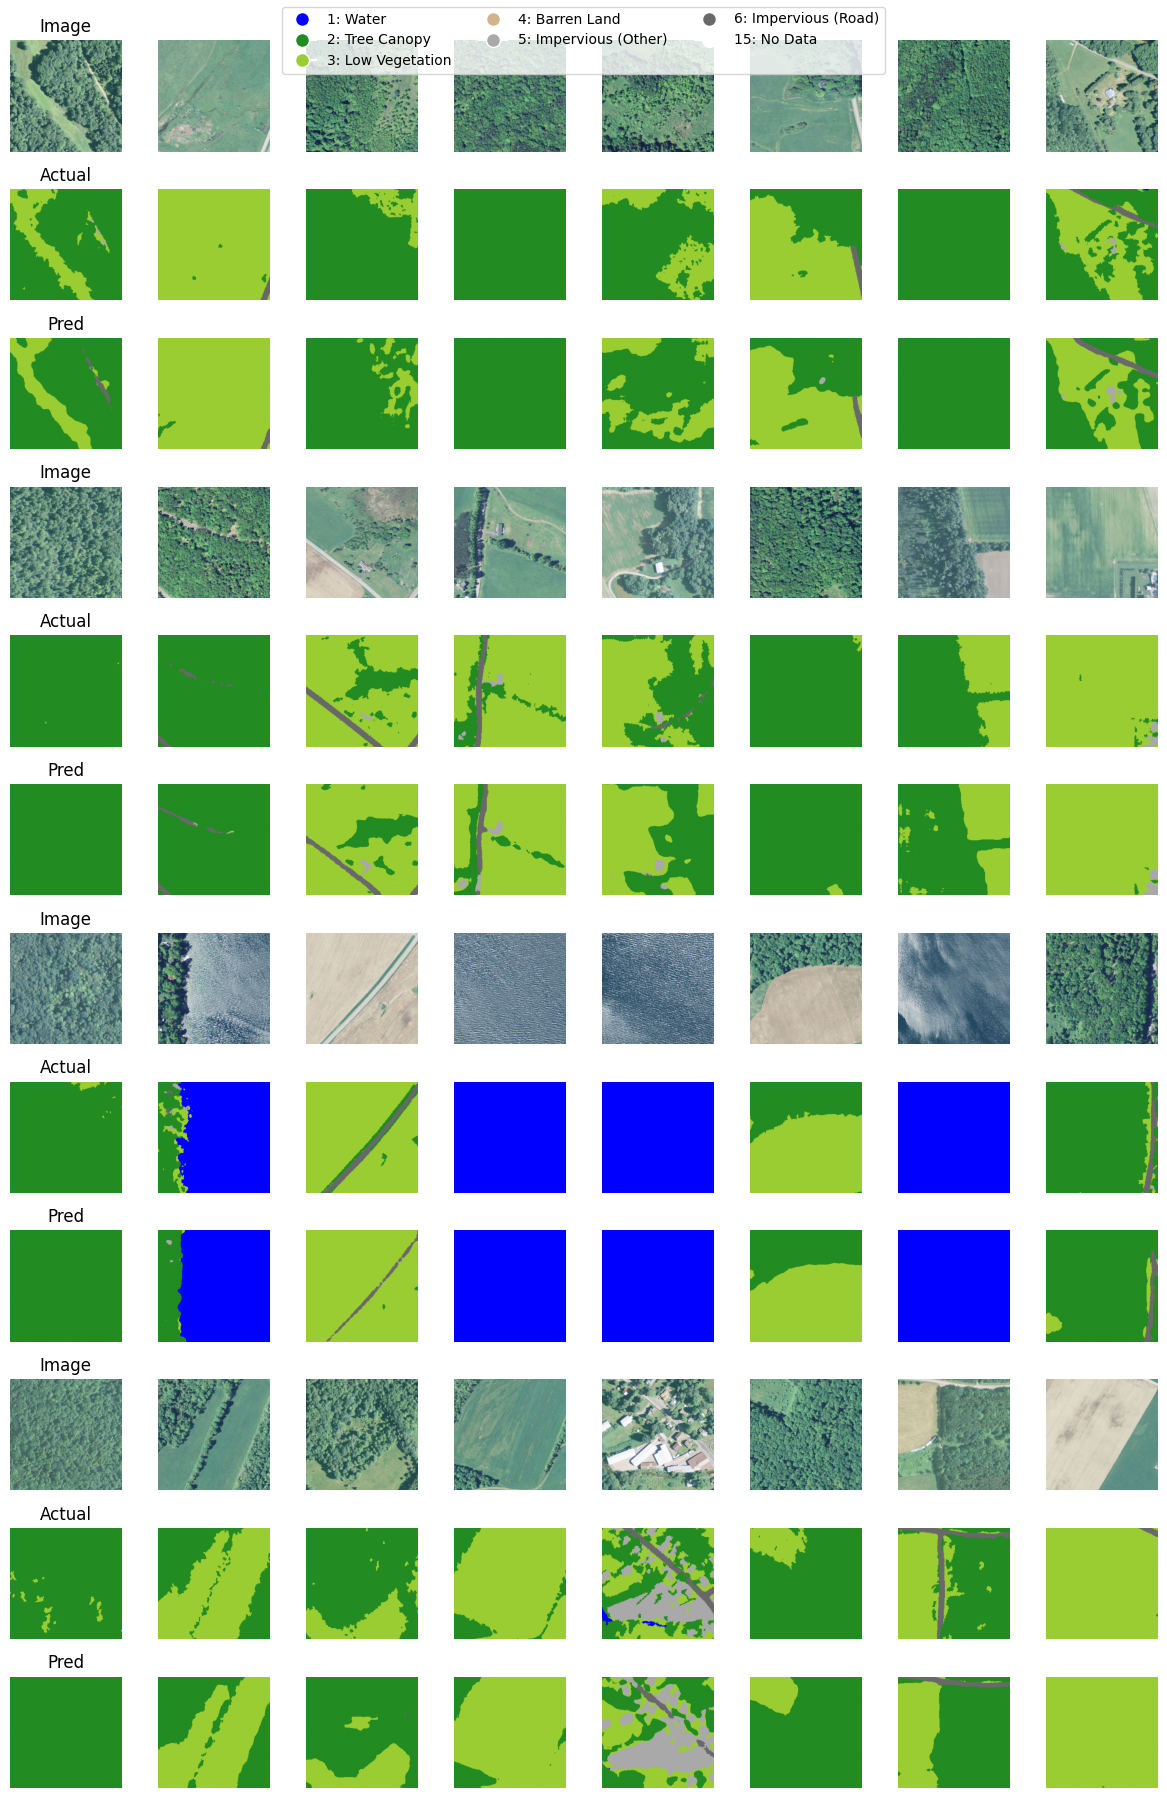

In [19]:
# Plot the predictions
plot_predictions(images, labels, preds)